# Import All the Libraries

In [83]:

# !pip install mplfinance
# !pip install yfinance
# !pip install git+https://github.com/kernc/backtesting.py.git

In [ ]:
# Uncomment the lines below to install talib on Google Colab
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz 
# %cd ta-lib
# !./configure --prefix=/usr --silent
# !make --silent
# !make install --silent
# !pip install Ta-Lib
# import talib

In [57]:
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import mplfinance as mpf
from datetime import datetime, timedelta
import mplfinance as mpf
import talib as talib
import seaborn as sns

# Get the Data

In [58]:
ticker_symbol = 'NVDA'

df = yf.download(ticker_symbol, start='2023-01-01')

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['NVDA']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


In [59]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


# Data Analysis

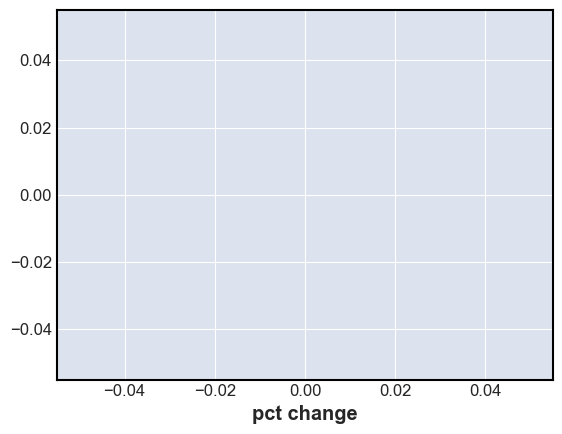

In [60]:
import matplotlib.pyplot as plt

ax = sns.histplot(df['Close'].pct_change())
ax.set(xlabel="pct change")
plt.show()

In [61]:
ticker_symbol = 'AAPL'

df = yf.download(ticker_symbol, start='2015-01-01')
start_yr = df.groupby(df.index.year).first()['Close']
end_yr = df.groupby(df.index.year).last()['Close']

annual_returns = (end_yr-start_yr)/start_yr

annual_returns


[*********************100%%**********************]  1 of 1 completed


Date
2015   -0.037227
2016    0.099383
2017    0.456995
2018   -0.084291
2019    0.859486
2020    0.767138
2021    0.372151
2022   -0.286138
2023    0.539378
2024    0.270524
Name: Close, dtype: float64

<Axes: xlabel='Date', ylabel='Close'>

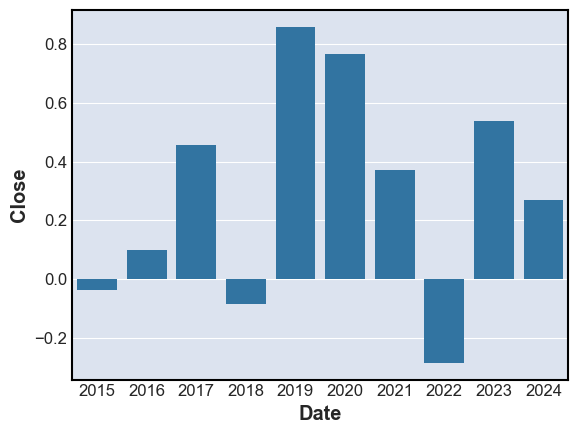

In [62]:
sns.barplot(annual_returns)

# Plotting and Charting

In [63]:
ticker_symbol = 'NVDA'

df = yf.download(ticker_symbol, start='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


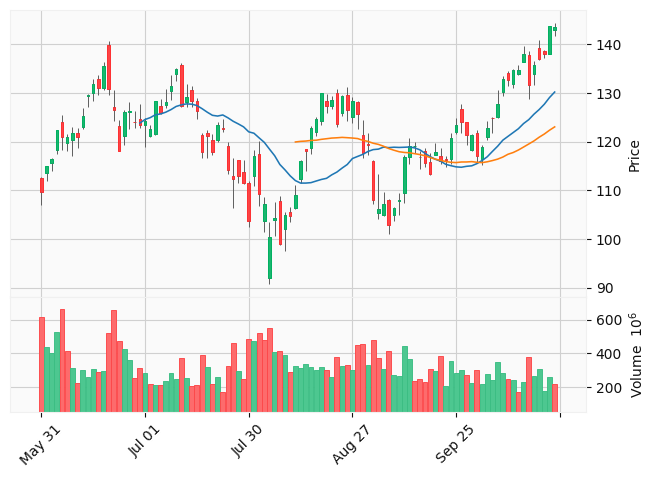

In [64]:
mpf.plot(df.tail(100),type='candle',style='yahoo',volume=True, mav=(20, 50))

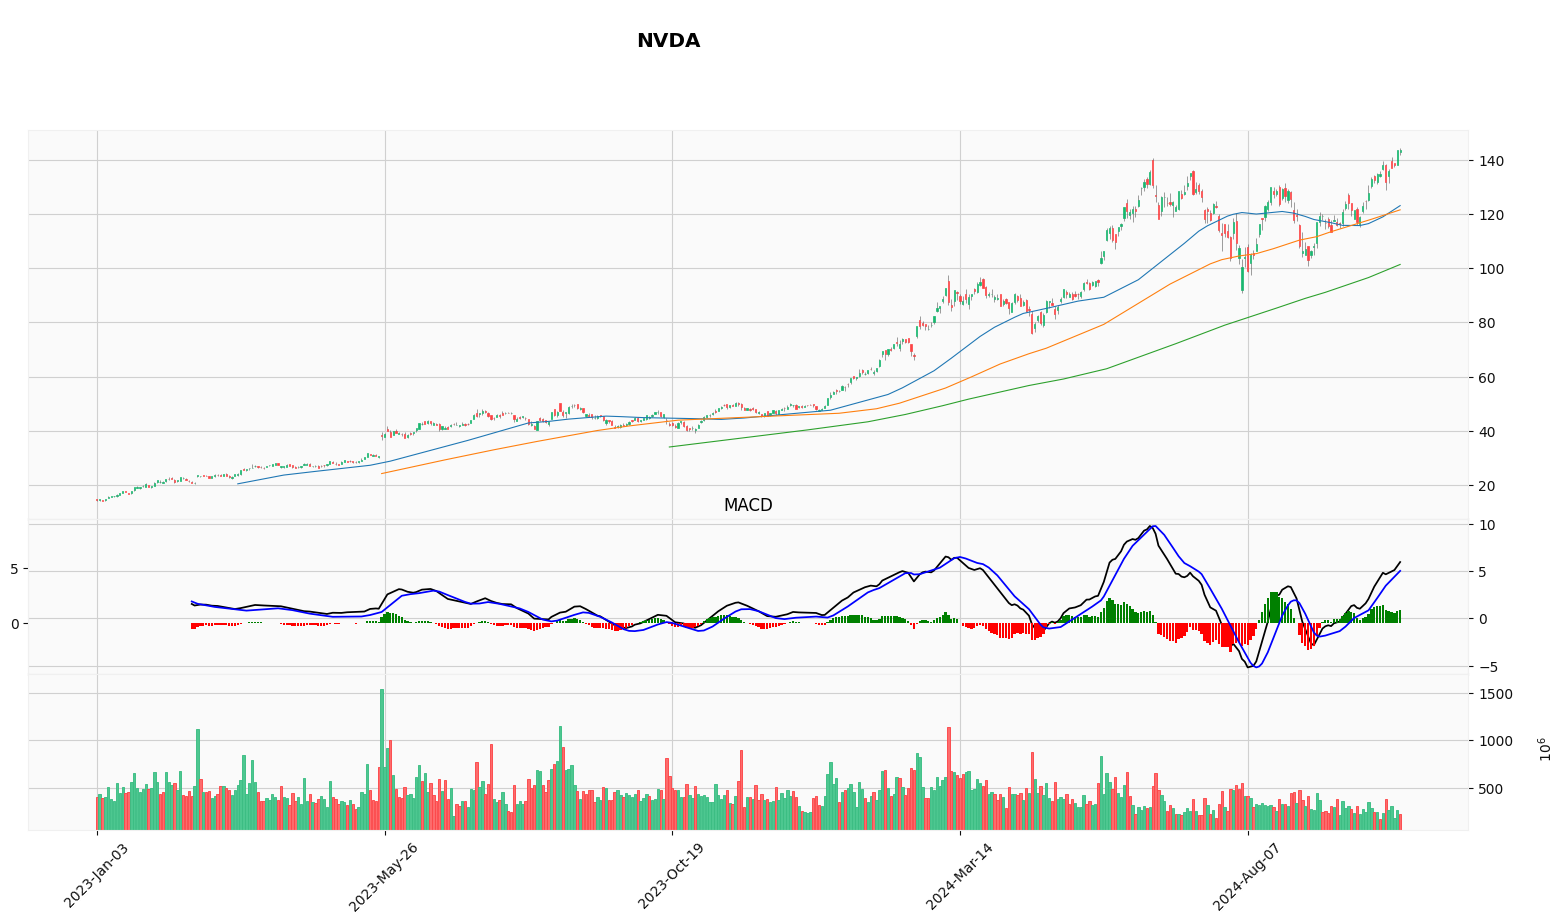

In [65]:
df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df['Close'])
# macd panel
colors = ['g' if v >= 0 else 'r' for v in df["macd_hist"]]
macd_plot = mpf.make_addplot(df["macd"], panel=1, color='black', title="MACD")
macd_hist_plot = mpf.make_addplot(df["macd_hist"], type='bar', panel=1, color=colors) # color='dimgray'
macd_signal_plot = mpf.make_addplot(df["macd_signal"], panel=1, color='b')
# plot
plots = [macd_plot, macd_signal_plot, macd_hist_plot]
mpf.plot(df, type='candle', style='yahoo', mav=(50,100,200), addplot=plots, title=f"\n{ticker_symbol}", volume=True, volume_panel=2, ylabel='', ylabel_lower='', figsize=(20,10))

## Bollinger Bands

(<Figure size 1600x1150 with 4 Axes>,
 [<Axes: ylabel='Price'>,
  <Axes: >,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >])

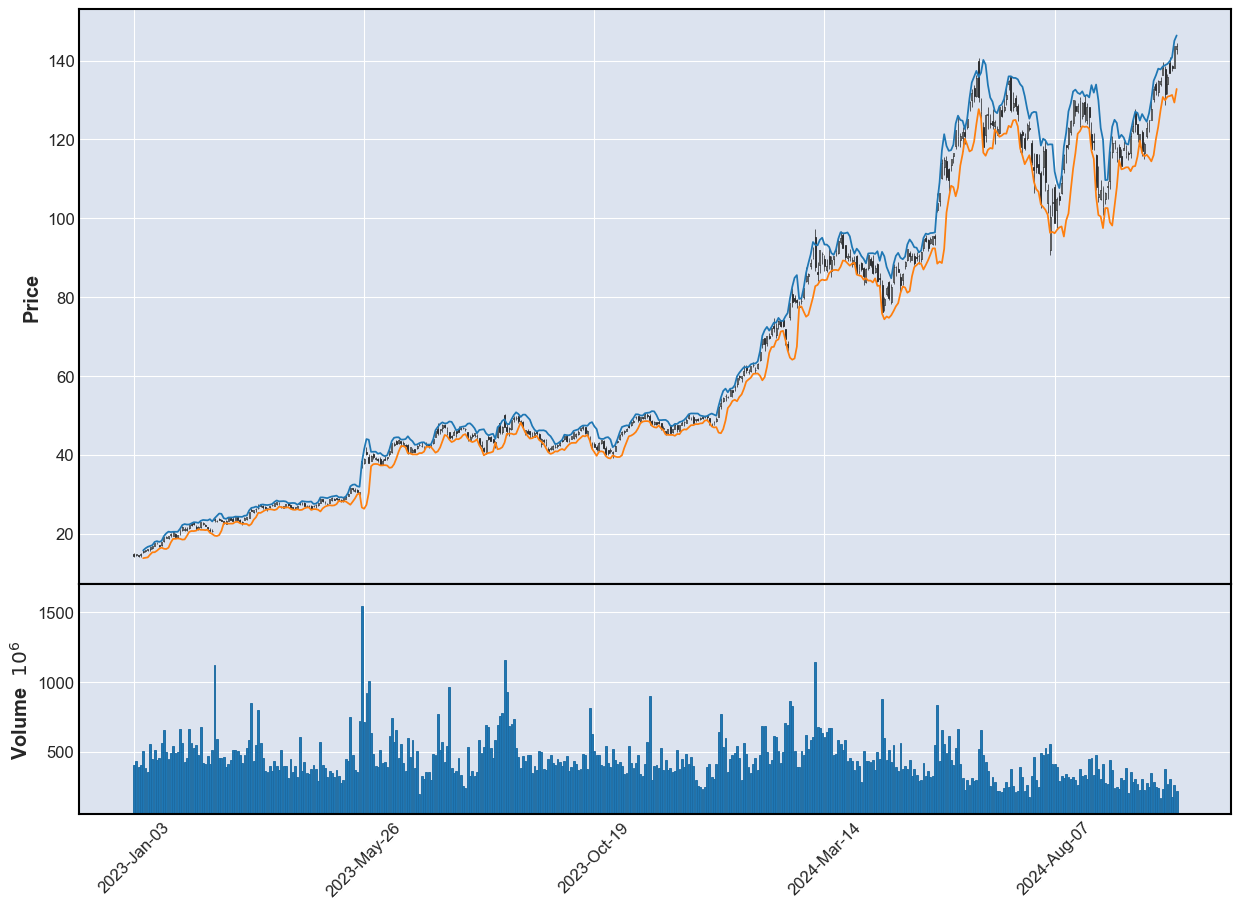

In [66]:
# Calculate Bollinger Band
df["upperband"], df["middleband"], df["lowerband"] = talib.BBANDS(df["Close"], timeperiod=5, 
                                                                      nbdevup=2, nbdevdn=2, matype=0)
    # Prune data to last 30 values
#df = df[-30:]


# Place Upper and Lower Bollinger Band in Upper Panel
mpfBB = mpf.make_addplot(df[["upperband", "lowerband"]])

    # List of added Plots
addedPlots = [mpfBB]

# Generate the plots and and return the figure
mpf.plot(df, type='candlestick', volume=True, returnfig=True, addplot=addedPlots, figscale=2.0)


## RSI Plot

(<Figure size 1600x1150 with 6 Axes>,
 [<Axes: ylabel='Price'>,
  <Axes: >,
  <Axes: ylabel='RSI'>,
  <Axes: >,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >])

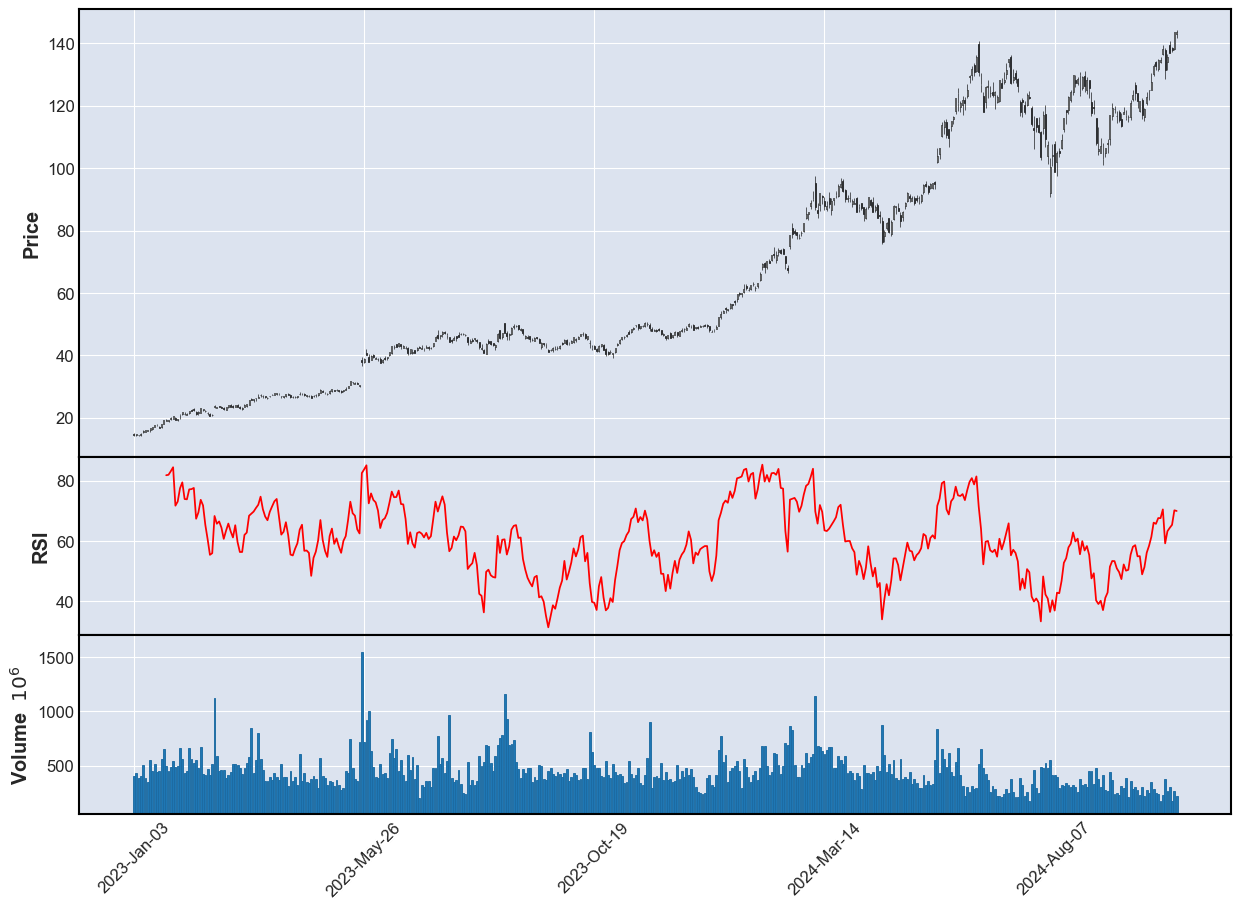

In [67]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)


apds = [
    mpf.make_addplot(df['RSI'], ylabel='RSI', panel=1, color="red"),
]


# Generate the plots and and return the figure
mpf.plot(df, type='candlestick', volume=True, returnfig=True, addplot=apds, figscale=2.0, volume_panel = 2)


In [68]:
# Backtesting

Using Backtesting library

In [69]:

from backtesting import Backtest, Strategy
from backtesting.test import SMA, GOOG
from backtesting.test import SMA
from backtesting.lib import crossover
import pandas as pd

class SmaCross(Strategy):
    n1 = 20 # period of the first SMA
    n2 = 50 # period of the second SMA

    def init(self):
        close = self.data.Close # close price data
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)
      
    def next(self):
      if crossover(self.sma1, self.sma2):
          self.buy()
      elif crossover(self.sma2, self.sma1):
          self.sell()

In [70]:
from backtesting import Backtest

bt = Backtest(df, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/Users/an/.pyenv/versions/3.11.1/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


GridPlot(id='p2545', ...)

In [71]:
print(output)

Start                     2023-01-03 00:00:00
End                       2024-10-22 00:00:00
Duration                    658 days 00:00:00
Exposure Time [%]                   59.251101
Equity Final [$]                 14219.677736
Equity Peak [$]                   19257.17681
Return [%]                          42.196777
Buy & Hold Return [%]              903.073703
Return (Ann.) [%]                   21.580498
Volatility (Ann.) [%]               61.626346
Sharpe Ratio                         0.350183
Sortino Ratio                        0.676978
Calmar Ratio                          0.35846
Max. Drawdown [%]                  -60.203352
Avg. Drawdown [%]                   -9.755236
Max. Drawdown Duration      126 days 00:00:00
Avg. Drawdown Duration       25 days 00:00:00
# Trades                                    8
Win Rate [%]                             37.5
Best Trade [%]                      74.422621
Worst Trade [%]                    -14.876484
Avg. Trade [%]                    

In [72]:


from backtesting import Backtest, Strategy
from backtesting.test import SMA, GOOG
from backtesting.test import SMA
from backtesting.lib import crossover
from talib import EMA

import pandas as pd

class EmaCross(Strategy):
    n1 = 8 # period of the first SMA
    n2 = 20 # period of the second SMA

    def init(self):
        close = self.data.Close # close price data
        self.ema1 = self.I(EMA, close, self.n1)
        self.ema2 = self.I(EMA, close, self.n2)
      
    def next(self):
      if crossover(self.ema1, self.ema2):
          self.buy()
      elif crossover(self.ema2, self.ema1):
          self.sell()

In [73]:
from backtesting import Backtest

bt = Backtest(df, EmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/Users/an/.pyenv/versions/3.11.1/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


GridPlot(id='p3578', ...)

In [74]:
print(output)

Start                     2023-01-03 00:00:00
End                       2024-10-22 00:00:00
Duration                    658 days 00:00:00
Exposure Time [%]                   66.740088
Equity Final [$]                  14122.29019
Equity Peak [$]                  17898.581015
Return [%]                          41.222902
Buy & Hold Return [%]              903.073703
Return (Ann.) [%]                   21.117599
Volatility (Ann.) [%]               51.348901
Sharpe Ratio                         0.411257
Sortino Ratio                        0.774204
Calmar Ratio                         0.567282
Max. Drawdown [%]                  -37.225931
Avg. Drawdown [%]                   -9.986064
Max. Drawdown Duration      182 days 00:00:00
Avg. Drawdown Duration       30 days 00:00:00
# Trades                                   16
Win Rate [%]                             25.0
Best Trade [%]                      80.296566
Worst Trade [%]                       -14.401
Avg. Trade [%]                    

In [75]:
ticker_symbol = 'AAPL'

df = yf.download(ticker_symbol, start='2020-01-01')


[*********************100%%**********************]  1 of 1 completed


In [76]:
import pandas_ta as ta

class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    # Do as much initial computation as possible
    def init(self):
        self.rsi = self.I(ta.rsi, pd.Series(self.data.Close), self.rsi_window)

    # Step through bars one by one
    # Note that multiple buys are a thing here

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()


bt = Backtest(df, RsiOscillator, cash=10_000, commission=.002)
stats = bt.run()
bt.plot()


/Users/an/.pyenv/versions/3.11.1/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


GridPlot(id='p4664', ...)

In [77]:
print(stats['_trades'].to_string())

   Size  EntryBar  ExitBar  EntryPrice   ExitPrice          PnL  ReturnPct  EntryTime   ExitTime   Tag Duration
0   155        39      108   64.443632   82.562500  2808.424471   0.281158 2020-02-28 2020-06-08  None 101 days
1   104       290      377  122.835176  136.600006  1431.542296   0.112059 2021-02-26 2021-07-01  None 125 days
2   102       693      778  138.486427  148.029999   973.444349   0.068913 2022-10-03 2023-02-03  None 123 days
3    84       905      977  180.049382  190.250000   856.851875   0.056655 2023-08-08 2023-11-17  None 101 days
4    88      1009     1100  182.353986  190.470001   714.209383   0.044507 2024-01-05 2024-05-16  None 132 days


In [78]:
def MACD(close, n1, n2, ns):
    #n1-n2
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=n1, slowperiod=n2, signalperiod=ns)
    return macd, macdsignal

class MACDCross(Strategy):
    n1 = 12 
    n2 = 26 
    ns = 9 

    def init(self):
        self.macd, self.macdsignal = self.I(MACD, self.data.Close, self.n1, self.n2, self.ns)

    def next(self): 
        if crossover(self.macd, self.macdsignal): 
            self.buy() 
        elif crossover(self.macdsignal, self.macd): 
            self.position.close() 

In [79]:
bt = Backtest(df, MACDCross, cash=10_000, commission=.002)
stats = bt.run()
bt.plot()


/Users/an/.pyenv/versions/3.11.1/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


GridPlot(id='p5788', ...)

In [80]:
stats

Start                     2020-01-02 00:00:00
End                       2024-10-22 00:00:00
Duration                   1755 days 00:00:00
Exposure Time [%]                   52.396694
Equity Final [$]                 22472.831621
Equity Peak [$]                  23700.976481
Return [%]                         124.728316
Buy & Hold Return [%]              214.113529
Return (Ann.) [%]                   18.368957
Volatility (Ann.) [%]               23.032981
Sharpe Ratio                         0.797507
Sortino Ratio                        1.464125
Calmar Ratio                         0.989655
Max. Drawdown [%]                  -18.560974
Avg. Drawdown [%]                   -4.593962
Max. Drawdown Duration      304 days 00:00:00
Avg. Drawdown Duration       45 days 00:00:00
# Trades                                   43
Win Rate [%]                        46.511628
Best Trade [%]                      25.079214
Worst Trade [%]                    -10.871222
Avg. Trade [%]                    

In [81]:
print(stats['_trades'].to_string())

    Size  EntryBar  ExitBar  EntryPrice   ExitPrice          PnL  ReturnPct  EntryTime   ExitTime   Tag Duration
0    157        59      101   63.313875   79.192497  2492.943694   0.250792 2020-03-27 2020-05-28  None  62 days
1    150       109      124   83.201074   90.019997  1022.838446   0.081957 2020-06-09 2020-06-30  None  21 days
2    140       130      137   96.455022   96.417503    -5.252602  -0.000389 2020-07-09 2020-07-20  None  11 days
3    135       138      139   99.370846   96.692497  -361.577028  -0.026953 2020-07-21 2020-07-22  None   1 days
4    121       147      171  108.416397  120.070000  1410.085933   0.107489 2020-08-03 2020-09-04  None  32 days
5    128       190      204  113.115779  117.449997   554.779848   0.038317 2020-10-02 2020-10-22  None  20 days
6    125       216      227  120.741000  113.910004  -853.874542  -0.056576 2020-11-09 2020-11-24  None  15 days
7    116       232      255  122.264037  127.720001   632.891892   0.044624 2020-12-02 2021-01-0